In [2]:
%run utils.py
%run model.py

In [3]:
SMILES_PATH = 'data/ADAGRASIB_SMILES.txt'
PATIENCE_THRESHOLD = 4

In [4]:
import rdkit 
from rdkit.Chem import MolFromSmiles as get_mol
from rdkit.Chem import rdDistGeom
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader, random_split
import multiprocessing
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [5]:
smi_list = get_smi_list(SMILES_PATH)

coor_list = parallel_f(get_atom_pos, smi_list)
longest_coor = len(max(coor_list, key = len))
coor_list = [pad(normalize(c), longest_coor) for c in coor_list]

smi_dic = get_dic(smi_list)
smint_list = [encode_smi(smi, smi_dic) for smi in smi_list]
longest_smint = len(max(smint_list, key = len))
smint_list = [pad_smi(smint, longest_smint, smi_dic) for smint in smint_list]

[12:23:38] UFFTYPER: Unrecognized atom type: Ba (0)


In [6]:
BATCH_SIZE = 128 
dataset = MyDataset(smint_list, coor_list)
train_set, val_set, test_set = random_split(dataset, [0.9, 0.05, 0.05])

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = True)

In [7]:
def train(model, num_epoch, lr) :
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss() 
    train_plot, val_plot = [], []
    best_val = float('inf')
    patience = 0 

    for epoch in tqdm(range(1, num_epoch + 1), total = num_epoch) :
        model.train() 

        train_loss, val_loss = 0, 0

        # TRAIN
        for input, target in train_loader : 
            input, target = input.to(device), target.to(device)
            prediction, _, _ = model(input) 
            loss = loss_fn(prediction, target)
            loss.backward() 
            optim.step() 
            optim.zero_grad()

            train_loss += loss.item()
            
        # VALIDATE
        model.eval()
        with torch.no_grad() :
            for input, target in val_loader :
                input, target = input.to(device), target.to(device)
                prediction, _, _ = model(input) 
                loss = loss_fn(prediction, target) 
                val_loss += loss.item() 
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        print(f'Train loss: {train_loss:.4f} --- Validate loss: {val_loss:.4f}')
        
        # EARLY STOPPING
        if val_loss < best_val :
            best_val = val_loss 
            patience = 0 
        else :
            patience += 1 
        
        if patience > PATIENCE_THRESHOLD : 
            print("EARLY STOPPING !!!")
            plt.plot(x, train_plot, color = 'blue', label = 'Train Loss')
            plt.plot(x, val_plot, color = 'red', label = 'Validation Loss')
            plt.title("Final Plot Before Loss")
            plt.legend()
            plt.show()
            break

        train_plot.append(train_loss), val_plot.append(val_loss)
        x = np.linspace(0, num_epoch, epoch)
        if epoch % 5 == 0 :
            plt.plot(x, train_plot, color = 'blue', label = 'Train Loss')
            plt.plot(x, val_plot, color = 'red', label = 'Validation Loss')
            plt.title(f'Epoch {epoch}')
            plt.legend()
            plt.show()

In [16]:
DIM_MODEL = 512
NUM_BLOCK = 4
NUM_HEAD = 4 
DROPOUT = 0.5 

In [17]:
model = Model(DIM_MODEL, NUM_BLOCK, NUM_HEAD, DROPOUT, longest_coor, smi_dic).to(device)

  0%|          | 0/100 [00:00<?, ?it/s]

Train loss: 2.2006 --- Validate loss: 2.0691
Train loss: 2.1077 --- Validate loss: 2.0267
Train loss: 2.1441 --- Validate loss: 2.0900
Train loss: 2.1368 --- Validate loss: 2.0403
Train loss: 2.1082 --- Validate loss: 2.0361


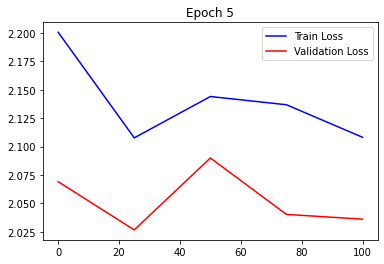

Train loss: 2.0894 --- Validate loss: 2.0177
Train loss: 2.0829 --- Validate loss: 2.0182
Train loss: 2.0830 --- Validate loss: 2.0168
Train loss: 2.0863 --- Validate loss: 2.0117
Train loss: 2.0810 --- Validate loss: 2.0090


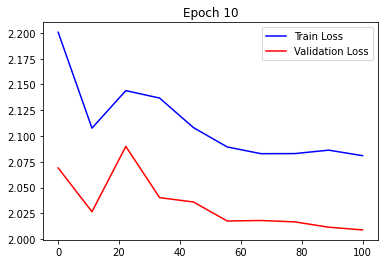

Train loss: 2.0813 --- Validate loss: 2.0131
Train loss: 2.0805 --- Validate loss: 2.0167
Train loss: 2.0826 --- Validate loss: 2.0229


KeyboardInterrupt: 

In [18]:
train(model, num_epoch=100,lr=0.001)